#############################          
探索DSR分数与年龄、教材的关系             
 
流程：         
    1. 连接数据库saybot_vw，基于exercise_id查找题目的教材名；基于userID查找birth_date
    2. 基于教材作调整
#############################

In [2]:
%matplotlib inline
from __future__ import division
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
# pd.options.display.max_rows = 12
np.set_printoptions(precision=4, suppress=True)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 4))
pd.set_option('display.max_columns', None) #输出所有列
import MySQLdb
import psycopg2
import matplotlib
matplotlib.style.use('ggplot')
import seaborn as sns
from datetime import datetime
from mpl_toolkits.basemap import Basemap
import re
import random

ImportError: No module named psycopg2

In [4]:
df_data = pd.read_excel('dsr.xlsx')
df_data.head(3)

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id
0,ok,Guangzhou,624487,luggage,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725
1,ok,Yaocheng,799603,Good morning.,"{u'lat': 37.3325, u'lon': 114.7014}",Hebei,92,"[{u'status': u'ok', u'begin': 110, u'end': 340...",2018-06-10T04:26:14.376Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,11099918
2,ok,Baoding,584094,Let's play volleyball!,"{u'lat': 38.8511, u'lon': 115.4903}",Hebei,96,"[{u'status': u'ok', u'begin': 60, u'end': 470,...",2018-06-10T04:26:14.391Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,96977702


In [5]:
len(df_data)

22650

In [514]:
# connect db to get age course name
conn = MySQLdb.connect(host='192.168.50.100',user='rui.shi',passwd='YzA3NzU3MmNiODMw',db='saybot_vw')
exercise_tb = pd.read_sql('select course_unit_id, id from saybot_vw.exercise', conn)
courseUnit_tb = pd.read_sql('select course_id, id from saybot_vw.course_unit', conn)
course_tb = pd.read_sql('select ename, id from saybot_vw.course', conn)

In [515]:
df_data = pd.merge(df_data, exercise_tb, left_on='exercise_id', right_on='id').drop(['id'], axis=1)
df_data = pd.merge(df_data, courseUnit_tb, left_on='course_unit_id', right_on='id').drop(['id'], axis=1)
df_data = pd.merge(df_data, course_tb, left_on='course_id', right_on='id').drop(['id'], axis=1)
df_data[:3]

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,0,13156,1202,GE7 (3A)
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,0,13156,1202,GE7 (3A)
2,ok,Guangzhou,624492,TOOTHPASTE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,94,"[{u'status': u'ok', u'begin': 520, u'end': 182...",2018-06-10T04:27:04.956Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,0,13156,1202,GE7 (3A)


In [492]:
# connect redshift to get the birthdate
conn_re = psycopg2.connect(host='192.168.50.204',port='5438', database='production', user='rui.shi',password='shiruiSHIRUI123.')
user = pd.read_sql('select pspt_id, birth_dt, usr_id from edw_alo7.rz_usr_d', conn_re)

In [493]:
usrID = [np.int64(ps_id.strip()) for ps_id in user.pspt_id]
user['usrID'] = usrID

In [516]:
df_data = pd.merge(df_data, user, left_on='user_id', right_on='usrID')
df_data = df_data.drop(['usr_id', 'usrID'], axis=1)

In [517]:
df_data.head(3)

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,0,13156,1202,GE7 (3A),20979725,2008-07-08
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,0,13156,1202,GE7 (3A),20979725,2008-07-08
2,ok,Guangzhou,624492,TOOTHPASTE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,94,"[{u'status': u'ok', u'begin': 520, u'end': 182...",2018-06-10T04:27:04.956Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,0,13156,1202,GE7 (3A),20979725,2008-07-08


In [518]:
# calculate age by birth date
age = []
for i in range(len(df_data)):
    try: 
        age.append(datetime.now().year - df_data.birth_dt[i].year)
    except:
        # replace the 
        age.append(0)
df_data['age'] = age

In [519]:
df_data.to_excel('dsr_all.xlsx')

---------------

In [520]:
# import data
df_dsr = pd.read_excel('dsr_all.xlsx')
df_dsr.head(3)

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00
2,ok,Guangzhou,624492,TOOTHPASTE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,94,"[{u'status': u'ok', u'begin': 520, u'end': 182...",2018-06-10T04:27:04.956Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00


In [521]:
# 加入星级
star = []
for sc in df_dsr.score:
    if sc < 60:
        star.append(1)
    elif (sc>=60) & (sc<85):
        star.append(2)
    else:
        star.append(3)
df_dsr['star'] = star

In [522]:
df_dsr.head(3)

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt,star
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2
2,ok,Guangzhou,624492,TOOTHPASTE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,94,"[{u'status': u'ok', u'begin': 520, u'end': 182...",2018-06-10T04:27:04.956Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,3


# 年龄分布
--以此过滤掉年龄大于20的数据

In [523]:
# drop the 0 age record
df_dsr = df_dsr.drop(df_dsr[df_dsr.age == 0].index, axis=0)
# split
df_young = df_dsr[df_dsr.age < 18]
df_adult = df_d·sr[df_dsr.age >= 18]

young: 22320     
adult: 278

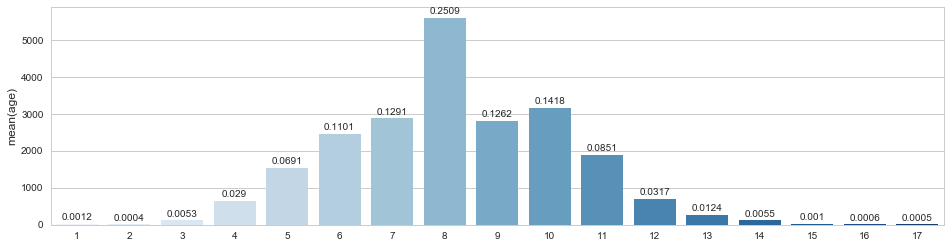

In [566]:
plt.rc('figure', figsize=(16, 4))
df_age = pd.DataFrame(df_young.age.value_counts()).sort_index()

# plot age
sns.set_style("whitegrid")
sns.barplot(x=df_age.index, y=df_age.age, palette='Blues')

for i in range(len(df_age)):
    plt.annotate(np.round(df_age.age.values[i] / len(df_young),4), (i, df_age.age.values[i]+100), horizontalalignment = 'center')

In [559]:
np.round(df_age.age.values[0] / len(df_young),4)

0.0012

# 分数分布

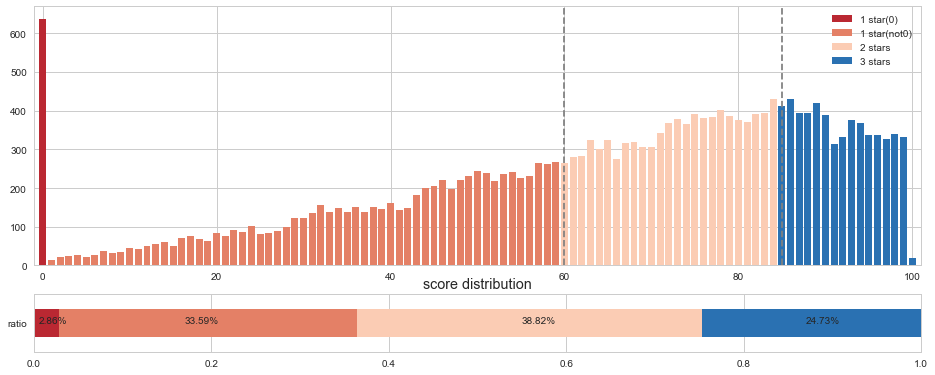

In [525]:
sns.set_style("whitegrid")
rect1 = [0.14, 0.35, 0.77, 0.9] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
rect2 = [0.14, 0.05, 0.77, 0.2]
ax1 = plt.axes(rect1)
ax2 = plt.axes(rect2)

# ax1
df_score = pd.DataFrame(df_young.score.value_counts()).sort_index()
ax1.bar(df_score[df_score.index == 0].index, 
        df_score[df_score.index == 0].score, 
        color=sns.color_palette("RdBu_r", 7)[6], label='1 star(0)')
ax1.bar(df_score[(df_score.index > 0) & (df_score.index < 60)].index, 
        df_score[(df_score.index > 0) & (df_score.index < 60)].score, 
        color=sns.color_palette("RdBu_r", 7)[5], label='1 star(not0)')
ax1.bar(df_score[(df_score.index >= 60) & (df_score.index < 85)].index, 
        df_score[(df_score.index >= 60) & (df_score.index < 85)].score, 
        color=sns.color_palette("RdBu_r", 7)[4], label='2 stars')
ax1.bar(df_score[df_score.index >= 85].index, 
        df_score[df_score.index >= 85].score, 
        color=sns.color_palette("RdBu_r", 7)[0], label='3 stars')
ax1.axvline(60, color='grey', linestyle='--')
ax1.axvline(85, color='grey', linestyle='--')
ax1.legend()
ax1.set_xlim(-1,101)

# ax2
df_star_ratio = pd.DataFrame()
df_star_ratio['ratio'] = [len(df_young[df_young.score == 0]) / len(df_young),
len(df_young[(df_young.score > 0) & (df_young.score < 60)]) / len(df_young), 
len(df_young[(df_young.score >= 60) & (df_young.score < 85)]) / len(df_young), 
len(df_young[df_young.score >= 85]) / len(df_young)]
df_star_ratio.index = ['1 star(0)', '1 star(not0)', '2 stars', '3 stars']
df_star_ratio.T.plot(kind='barh',stacked=True, legend=False,
                     color=[sns.color_palette("RdBu_r", 7)[6], sns.color_palette("RdBu_r", 7)[5],
                            sns.color_palette("RdBu_r", 7)[4], sns.color_palette("RdBu_r", 7)[0]], ax=ax2)
ax2.set_xlim(0,1)
ax2.annotate('2.86%',[0.005,0])
ax2.annotate('33.59%',[0.17,0])
ax2.annotate('38.82%',[0.55,0])
ax2.annotate('24.73%',[0.87,0])

plt.title('score distribution')

In [526]:
df_young.head(3)

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt,star
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2
2,ok,Guangzhou,624492,TOOTHPASTE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,94,"[{u'status': u'ok', u'begin': 520, u'end': 182...",2018-06-10T04:27:04.956Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,3


### 分数是否符合该年龄段小朋友的打分   

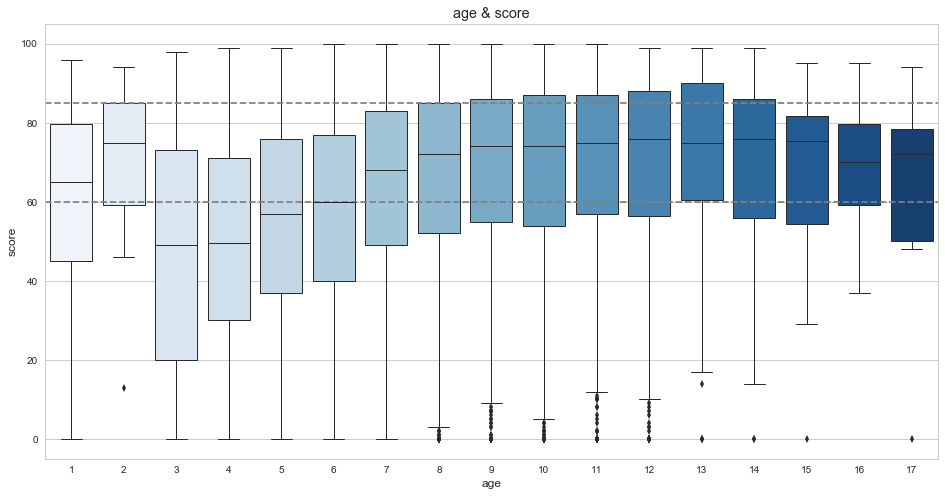

In [575]:
plt.rc('figure', figsize=(16, 8))
sns.boxplot(x="age", y="score", data=df_young, palette=sns.color_palette("Blues",17),linewidth=1)
plt.axhline(60, linestyle='--', color='grey')
plt.axhline(85, linestyle='--', color='grey')
plt.title("age & score")

### 分数是否符合该年龄段小朋友的打分

In [528]:
eName = ['SE1', 'SE2', 'SE3', 'SE4', 'SE5', 'SE6',
        'GE1(S_A)', 'GE2 (S_B)', 'GE3 (1A)', 'GE4 (1B)',
        'GE5 (2A)', 'GE6 (2B)', 'GE7 (3A)', 'GE8 (3B)',
        'GE9 (4A)', 'GE10 (4B)', 'GE11 (5A)', 'GE12 (5B)',
        'WE1', 'WE2']
df_book = df_young[[True if en in eName else False for en in df_young.ename.values]]

book_type = []
type_dif = []
for en in df_book.ename.values:
    if en in ['SE1', 'SE2', 'SE3', 'SE4', 'SE5', 'SE6']:
        book_type.append('SE')
        type_dif.append(1)
    elif en in ['WE1', 'WE2']:
        book_type.append('WE')
        type_dif.append(3)
    else:
        book_type.append('GE')
        type_dif.append(2)
df_book['type'] = book_type
df_book['type_dif'] = type_dif

eName_dic = {'SE1':1, 'SE2':2, 'SE3':3, 'SE4':4, 'SE5':5, 'SE6':6,
        'GE1(S_A)':7, 'GE2 (S_B)':8, 'GE3 (1A)':9, 'GE4 (1B)':10,
        'GE5 (2A)':11, 'GE6 (2B)':12, 'GE7 (3A)':13, 'GE8 (3B)':14,
        'GE9 (4A)':15, 'GE10 (4B)':16, 'GE11 (5A)':17, 'GE12 (5B)':18,
        'WE1':19, 'WE2':20}
book_dif = [eName_dic[en] for en in df_book.ename.values]
df_book['book_dif'] = book_dif

eName_re = {'SE1':'SE1', 'SE2':'SE2', 'SE3':'SE3', 'SE4':'SE4', 'SE5':'SE5', 'SE6':'SE6',
        'GE1(S_A)':'GE1', 'GE2 (S_B)':'GE2', 'GE3 (1A)':'GE3', 'GE4 (1B)':'GE4',
        'GE5 (2A)':'GE5', 'GE6 (2B)':'GE6', 'GE7 (3A)':'GE7', 'GE8 (3B)':'GE8',
        'GE9 (4A)':'GE9', 'GE10 (4B)':'GE10', 'GE11 (5A)':'GE10', 'GE12 (5B)':'GE12',
        'WE1':'WE1', 'WE2':'WE1'}
ename_re = [eName_re[en] for en in df_book.ename.values]
df_book['ename_re'] = ename_re

plt.rc('figure', figsize=(18, 7))
sns.boxplot(x="ename", y="score", data=df_book.sort_values(by='book_dif'), palette='BuGn',linewidth=1)
plt.axhline(60, linestyle='--', color='grey')
plt.axhline(85, linestyle='--', color='grey')
plt.title('book & score')

/Applications/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Applications/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


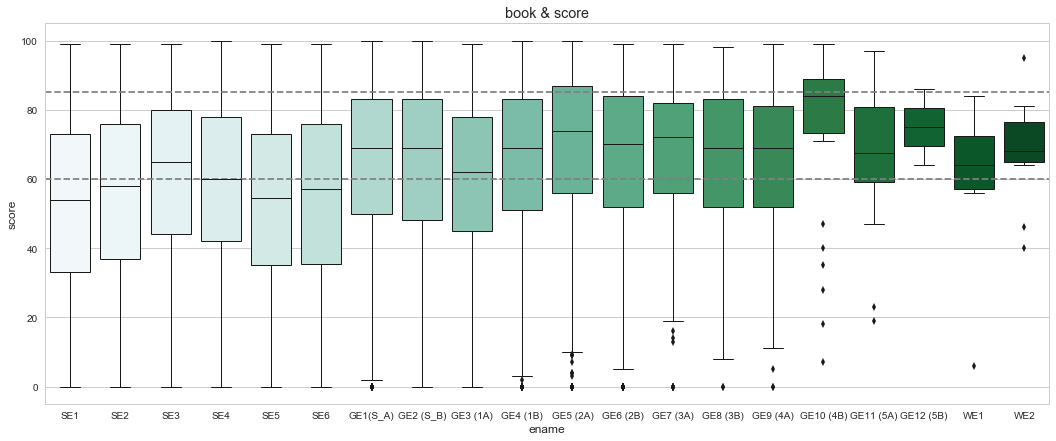

In [582]:
plt.rc('figure', figsize=(18, 7))
sns.boxplot(x="ename", y="score", data=df_book.sort_values(by='book_dif'), palette='BuGn',linewidth=1)
plt.axhline(60, linestyle='--', color='grey')
plt.axhline(85, linestyle='--', color='grey')
plt.title('book & score')

-------------

In [586]:
len(df_young[(df_young.age >= 4) & (df_young.age<12)]) / len(df_young)

0.9413820919602044

In [1009]:
df_young

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt,star,new_score,new_score_mean,new_score_mean_ts11
0,ok,Guangzhou,624487,LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'soso', u'begin': 580, u'end': 1...",2018-06-10T04:26:14.374Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2,81.0,85.0,85.0
1,soft,Guangzhou,624490,TAKE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'soso', u'begin': 980, u'end': 1...",2018-06-10T04:26:42.217Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2,83.0,87.0,87.0
2,ok,Guangzhou,624492,TOOTHPASTE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,94,"[{u'status': u'ok', u'begin': 520, u'end': 182...",2018-06-10T04:27:04.956Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,3,95.0,99.0,99.0
3,ok,Guangzhou,664627,CAN I BUY A BLOUSE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,91,"[{u'status': u'ok', u'begin': 460, u'end': 850...",2018-06-10T04:32:24.724Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,3,92.0,96.0,96.0
4,ok,Guangzhou,664629,NANI DOESN'T KNOW WHAT TO PUT IN HER LUGGAGE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,83,"[{u'status': u'bad', u'begin': 470, u'end': 10...",2018-06-10T04:33:07.419Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13156,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2,84.0,88.0,88.0
5,ok,Guangzhou,663651,HE IS GOOD AT FISHING,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,75,"[{u'status': u'bad', u'begin': 480, u'end': 11...",2018-06-10T04:24:33.540Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,18725,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2,76.0,80.0,80.0
6,ok,Guangzhou,709818,CHOOSE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,63,"[{u'status': u'soso', u'begin': 560, u'end': 1...",2018-06-10T03:55:57.511Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13163,1202,GE7 (3A),20979725,2008-07-08 00:00:00,2,64.0,68.0,68.0
7,ok,Guangzhou,709823,RUDE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,59,"[{u'status': u'bad', u'begin': 320, u'end': 12...",2018-06-10T03:57:09.233Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13163,1202,GE7 (3A),20979725,2008-07-08 00:00:00,1,60.0,64.0,64.0
8,ok,Guangzhou,709823,RUDE,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,91,"[{u'status': u'ok', u'begin': 510, u'end': 132...",2018-06-10T03:57:21.304Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,13163,1202,GE7 (3A),20979725,2008-07-08 00:00:00,3,92.0,96.0,96.0
9,ok,Guangzhou,709884,LELE IS QUITE A GOOD DANCER,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,91,"[{u'status': u'soso', u'begin': 340, u'end': 1...",2018-06-10T04:14:47.704Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,20979725,10,18748,1202,GE7 (3A),20979725,2008-07-08 00:00:00,3,92.0,96.0,96.0


In [1004]:
df_young.iloc[127]

audio_quality                                                         ok
city_name                                                      Zhengzhou
exercise_id                                                       709817
hyp_text                                                           BRAVE
location                             {u'lat': 34.6836, u'lon': 113.5325}
region_name                                                        Henan
score                                                                 71
segments               [{u'status': u'soso', u'begin': 430, u'end': 1...
timestamp                                       2018-06-15T04:37:58.355Z
url                    https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...
user_id                                                         66334292
age                                                                   11
course_unit_id                                                     13163
course_id                                          

-------

### 调节阈值

In [632]:
def plotDis(low, high):
    plt.rc('figure', figsize=(16, 4))
    sns.set_style("whitegrid")
    rect1 = [0.14, 0.35, 0.77, 0.9] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
    rect2 = [0.14, 0.05, 0.77, 0.2]
    ax1 = plt.axes(rect1)
    ax2 = plt.axes(rect2)

    # ax1
    df_score = pd.DataFrame(df_young.score.value_counts()).sort_index()
    ax1.bar(df_score[df_score.index < low].index, 
            df_score[df_score.index < low].score, 
            color=sns.color_palette("RdBu_r", 7)[5], label='1 star(not0)')
    ax1.bar(df_score[(df_score.index >= low) & (df_score.index < high)].index, 
            df_score[(df_score.index >= low) & (df_score.index < high)].score, 
            color=sns.color_palette("RdBu_r", 7)[4], label='2 stars')
    ax1.bar(df_score[df_score.index >= high].index, 
            df_score[df_score.index >= high].score, 
            color=sns.color_palette("RdBu_r", 7)[0], label='3 stars')
    ax1.axvline(low, color='grey', linestyle='--')
    ax1.axvline(high, color='grey', linestyle='--')
    ax1.legend()
    ax1.set_xlim(-1,101)

    # ax2
    df_star_ratio = pd.DataFrame()
    df_star_ratio['ratio'] = [len(df_young[df_young.score<low]) / len(df_young), 
    len(df_young[(df_young.score >= low) & (df_young.score < high)]) / len(df_young), 
    len(df_young[df_young.score >= high]) / len(df_young)]
    df_star_ratio.index = ['1 star', '2 stars', '3 stars']
    df_star_ratio.T.plot(kind='barh',stacked=True, legend=False,
                         color=[sns.color_palette("RdBu_r", 7)[5],
                            sns.color_palette("RdBu_r", 7)[4], sns.color_palette("RdBu_r", 7)[0]], ax=ax2)
    ax2.set_xlim(0,1)
    ax2.annotate(str(np.round(df_star_ratio.values[0][0]*100,2))+'%',[0,0])
    ax2.annotate(str(np.round(df_star_ratio.values[1][0]*100,2))+'%',[df_star_ratio.values[0][0],0])
    ax2.annotate(str(np.round(df_star_ratio.values[2][0]*100,2))+'%',[df_star_ratio.values[0][0] + df_star_ratio.values[1][0],0])

    plt.title('score distribution')

In [680]:
def catRatio():
    ratio = {}
    for low in range(45, 61):
        for high in range(80, 86):
            ratio[str(low)+'|'+str(high)] = [len(df_young[df_young.score < low]) / len(df_young), 
                                             len(df_young[(df_young.score >= low) & (df_young.score < high)]) / len(df_young), 
                                             len(df_young[df_young.score >= high]) / len(df_young)]
    return ratio

In [681]:
df_ratio = pd.DataFrame(catRatio())
df_ratio.index = [1,2,3]
df_ratio.T.to_excel('threshold.xlsx')

In [1031]:
city_name = ['ulumuqi' if cname==u'\xdcr\xfcmqi' else cname for cname in df_young.city_name.values]
df_young['city_name'] = city_name
df_young.to_csv('young.csv')

----------

### 基于教材、年龄的分数调整

方案一：让阈值在每本教材上的划分都保持几近的比例

① 72.5(60,85)中值与ename的median的差值

In [911]:
df_ename = df_young.groupby('ename').score.describe()
df_ename.head(3)

,count,mean,std,min,25%,50%,75%,max
ename,,,,,,,,
ABC Books,56.0,48.232143,32.009085,0.0,21.75,49.0,69.50,99.0
AiZuoYe Trial,61.0,57.196721,30.678885,0.0,29.00,64.0,84.00,94.0
Alo7 English for Kids 1A,194.0,69.195876,21.342817,0.0,59.25,75.0,85.75,98.0


In [839]:
# 以72.5与meadian的差值来调整
median_dict = df_ename[['50%']].to_dict()['50%']
adjust_dict = {k:72.5-v for k, v in median_dict.items()}
score_adj = [df_young.score[i]+adjust_dict[df_young.ename[i]] for i in range(len(df_young))]

In [870]:
# 调整后的数值可能大于100或小于0，让这些数据随机生成一个【90-100】或【0-10】之间的随机数
new_score = []
for i in range(len(score_adj)):
    if score_adj[i] > 100:
        new_score.append(random.randrange(90,101,1))
    elif score_adj[i] < 0:
        new_score.append(random.randrange(0,11,1))
    else:
        new_score.append(np.ceil(score_adj[i]))
df_young['new_score'] = new_score

In [893]:
# 划分后比例变化
df_star_ratio = pd.DataFrame()
df_star_ratio['ratio_old'] = [len(df_young[df_young.score < 60]) / len(df_young),
len(df_young[(df_young.score >= 60) & (df_young.score < 85)]) / len(df_young), 
len(df_young[df_young.score >= 85]) / len(df_young)]
df_star_ratio['ratio_new'] = [len(df_young[df_young.new_score < 60]) / len(df_young),
len(df_young[(df_young.new_score >= 60) & (df_young.new_score < 85)]) / len(df_young), 
len(df_young[df_young.new_score >= 85]) / len(df_young)]
df_star_ratio.index = ['1 star', '2 stars', '3 stars']

② 72.5(60,85)中值与ename的mean的差值

In [913]:
# 以72.5与meadian的差值来调整
mean_dict = df_ename[['mean']].to_dict()['mean']
adjust_dict = {k:72.5-v for k, v in mean_dict.items()}
score_adj = [df_young.score[i]+adjust_dict[df_young.ename[i]] for i in range(len(df_young))]

In [914]:
# 调整后的数值可能大于100或小于0，让这些数据随机生成一个【90-100】或【0-10】之间的随机数
new_score = []
for i in range(len(score_adj)):
    if score_adj[i] > 100:
        new_score.append(random.randrange(90,101,1))
    elif score_adj[i] < 0:
        new_score.append(random.randrange(0,11,1))
    else:
        new_score.append(np.ceil(score_adj[i]))
df_young['new_score_mean'] = new_score

In [916]:
# 划分后比例变化
df_star_ratio = pd.DataFrame()
df_star_ratio['ratio_old'] = [len(df_young[df_young.score < 60]) / len(df_young),
len(df_young[(df_young.score >= 60) & (df_young.score < 85)]) / len(df_young), 
len(df_young[df_young.score >= 85]) / len(df_young)]
df_star_ratio['ratio_median'] = [len(df_young[df_young.new_score < 60]) / len(df_young),
len(df_young[(df_young.new_score >= 60) & (df_young.new_score < 85)]) / len(df_young), 
len(df_young[df_young.new_score >= 85]) / len(df_young)]
df_star_ratio['ratio_mean'] = [len(df_young[df_young.new_score_mean < 60]) / len(df_young),
len(df_young[(df_young.new_score_mean >= 60) & (df_young.new_score_mean < 85)]) / len(df_young), 
len(df_young[df_young.new_score_mean >= 85]) / len(df_young)]
df_star_ratio.index = ['1 star', '2 stars', '3 stars']

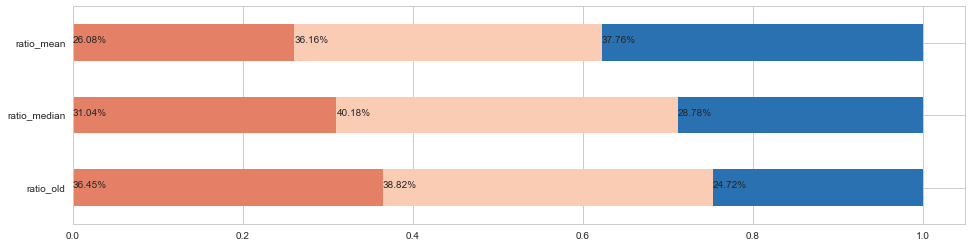

In [924]:
plt.rc('figure', figsize=(16,4))
df_star_ratio.T.plot(kind='barh',stacked=True, legend=False,
                     color=[sns.color_palette("RdBu_r", 7)[5],
                            sns.color_palette("RdBu_r", 7)[4], sns.color_palette("RdBu_r", 7)[0]])
for i in range(len(df_star_ratio.columns)):
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[0]*100,2))+"%",[0,i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[1]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0],i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[2]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0] + df_star_ratio.' + df_star_ratio.columns[i] +'.values[1],i])')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

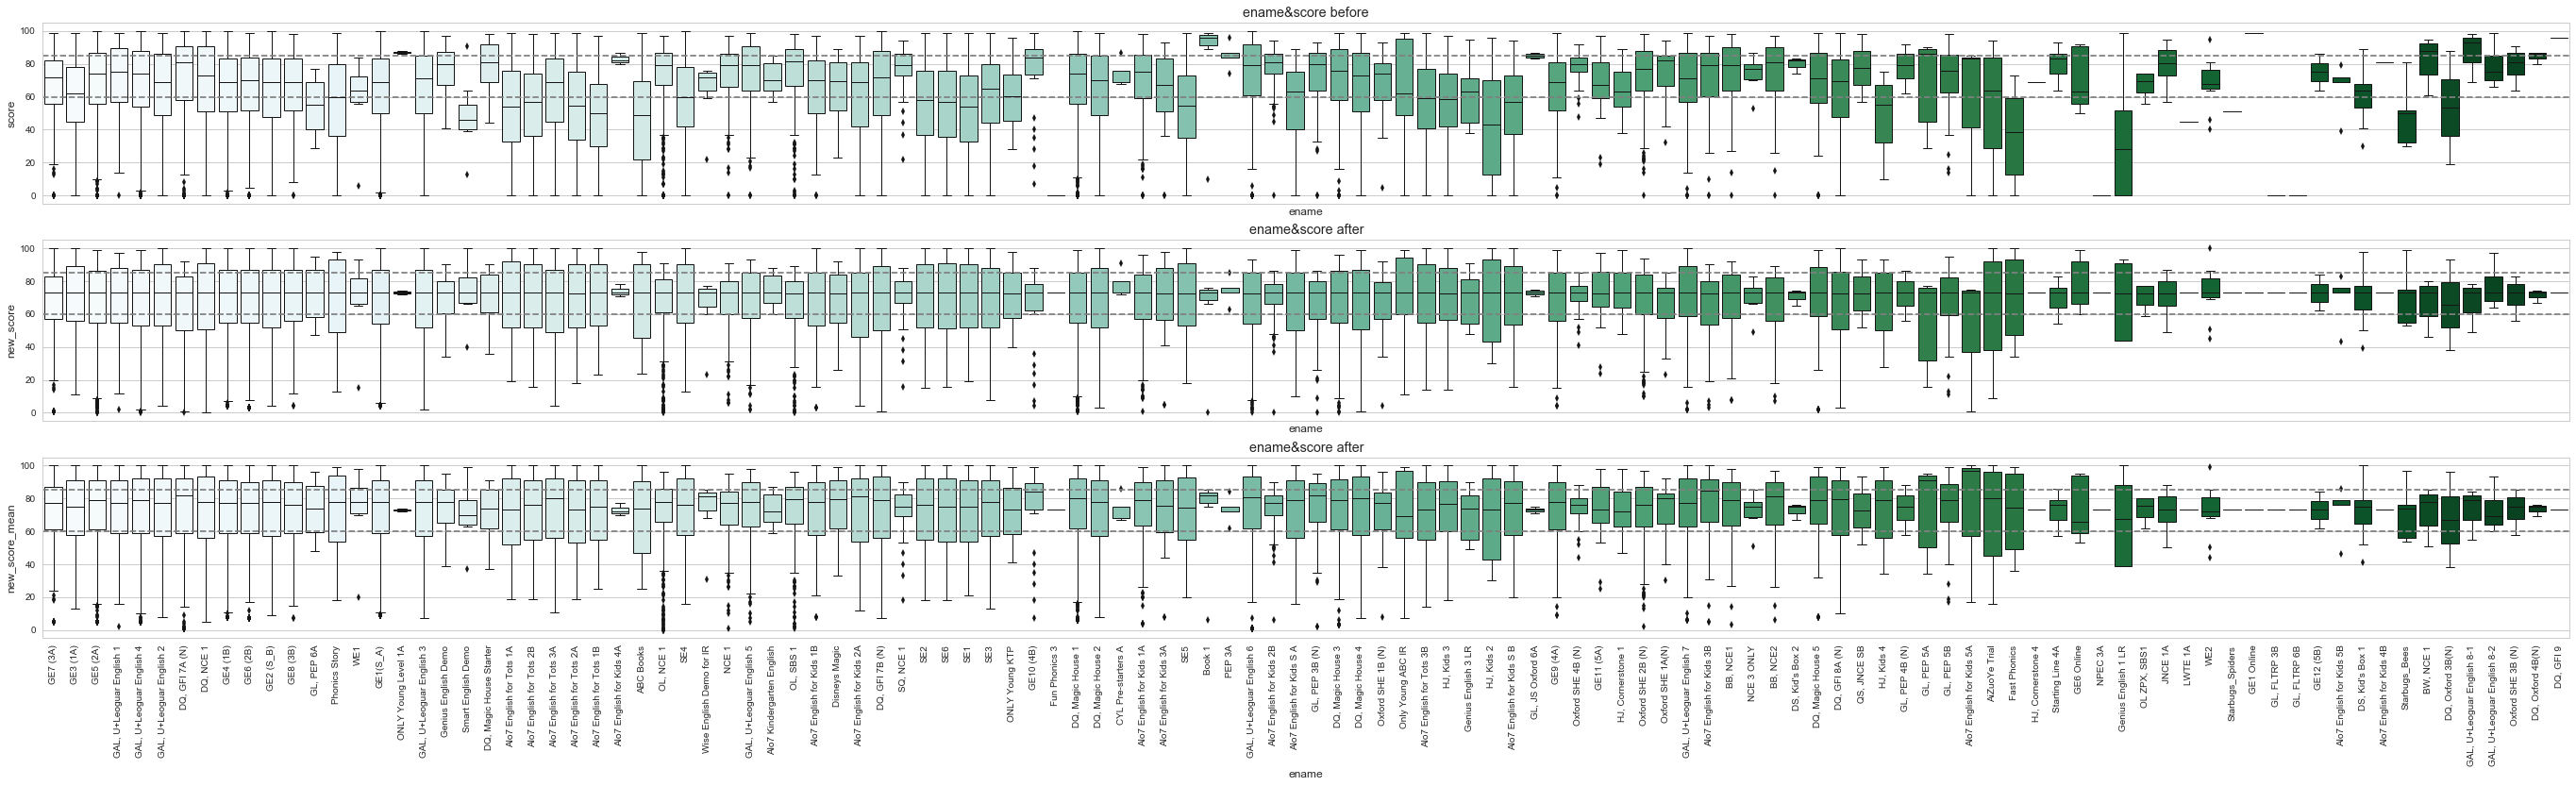

In [929]:
# 划分前后教材的分数分布
f, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(48, 12), sharex=True)

sns.boxplot(x="ename", y="score", data=df_young, palette='BuGn',linewidth=1, ax=ax1)
ax1.axhline(60, linestyle='--', color='grey')
ax1.axhline(85, linestyle='--', color='grey')
ax1.set_title('ename&score before')

sns.boxplot(x="ename", y="new_score", data=df_young, palette='BuGn',linewidth=1, ax=ax2)
ax2.axhline(60, linestyle='--', color='grey')
ax2.axhline(85, linestyle='--', color='grey')
ax2.set_title('ename&score after')

sns.boxplot(x="ename", y="new_score_mean", data=df_young, palette='BuGn',linewidth=1, ax=ax3)
ax3.axhline(60, linestyle='--', color='grey')
ax3.axhline(85, linestyle='--', color='grey')
ax3.set_title('ename&score after')

plt.xticks(rotation=90)

In [988]:
df_young[df_young.ename == 'Genius English 1 LR']

8

从上面的例子来看22205读的不错，22206，22207，22208， 22209，22211，22212声音大，几乎是乱读的，原来的分数更为客观

结果1：当前的分数调整，比例上近似满足需求，实际音频的给分出现了混乱，调整后有的记录原本属于1星，调整后属于3星，但实际调整后属于3星的读音远不如原来3星的好。     
原因：有的教材调整的数值太大了；考虑是否设置调整的分值的上下限

结果2：对于记录不多的教材，调节值的误差较大

In [992]:
pd.DataFrame(df_young.ename.value_counts())[:-60]

,ename
GE2 (S_B),1551
GE1(S_A),1463
GE4 (1B),1169
"GAL, U+Leoguar English 3",1169
GE3 (1A),1146
SE1,1036
"GAL, U+Leoguar English 4",899
"DQ, NCE 1",882
GE5 (2A),861
SE2,829


In [956]:
# 设置调整的阈值上限
new_adj_dict = {}
for k,v in adjust_dict.items():
    if v < -11:
        new_adj_dict[k] = -10
    elif v > 11:
        new_adj_dict[k] = 10
    else:
        new_adj_dict[k] = v
score_adj = [df_young.score[i]+new_adj_dict[df_young.ename[i]] for i in range(len(df_young))]

In [957]:
# 调整后的数值可能大于100或小于0，让这些数据随机生成一个【90-100】或【0-10】之间的随机数
new_score = []
for i in range(len(score_adj)):
    if score_adj[i] > 100:
        new_score.append(random.randrange(90,101,1))
    elif score_adj[i] < 0:
        new_score.append(random.randrange(0,11,1))
    else:
        new_score.append(np.ceil(score_adj[i]))
df_young['new_score_mean_ts11'] = new_score

In [960]:
# 划分后比例变化
df_star_ratio = pd.DataFrame()
df_star_ratio['ratio_old'] = [len(df_young[df_young.score < 60]) / len(df_young),
len(df_young[(df_young.score >= 60) & (df_young.score < 85)]) / len(df_young), 
len(df_young[df_young.score >= 85]) / len(df_young)]
df_star_ratio['ratio_median'] = [len(df_young[df_young.new_score < 60]) / len(df_young),
len(df_young[(df_young.new_score >= 60) & (df_young.new_score < 85)]) / len(df_young), 
len(df_young[df_young.new_score >= 85]) / len(df_young)]
df_star_ratio['ratio_mean'] = [len(df_young[df_young.new_score_mean < 60]) / len(df_young),
len(df_young[(df_young.new_score_mean >= 60) & (df_young.new_score_mean < 85)]) / len(df_young), 
len(df_young[df_young.new_score_mean >= 85]) / len(df_young)]
df_star_ratio['ratio_mean_ts11'] = [len(df_young[df_young.new_score_mean_ts11 < 60]) / len(df_young),
len(df_young[(df_young.new_score_mean_ts11 >= 60) & (df_young.new_score_mean_ts11 < 85)]) / len(df_young), 
len(df_young[df_young.new_score_mean_ts11 >= 85]) / len(df_young)]
df_star_ratio.index = ['1 star', '2 stars', '3 stars']

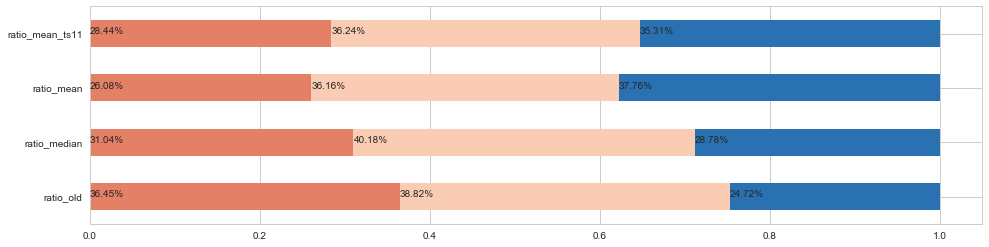

In [961]:
plt.rc('figure', figsize=(16,4))
df_star_ratio.T.plot(kind='barh',stacked=True, legend=False,
                     color=[sns.color_palette("RdBu_r", 7)[5],
                            sns.color_palette("RdBu_r", 7)[4], sns.color_palette("RdBu_r", 7)[0]])
for i in range(len(df_star_ratio.columns)):
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[0]*100,2))+"%",[0,i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[1]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0],i])')
    eval('plt.annotate(str(np.round(df_star_ratio.' + df_star_ratio.columns[i] +'.values[2]*100,2))+"%",[df_star_ratio.' + df_star_ratio.columns[i] +'.values[0] + df_star_ratio.' + df_star_ratio.columns[i] +'.values[1],i])')

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]),
 <a list of 116 Text xticklabel objects>)

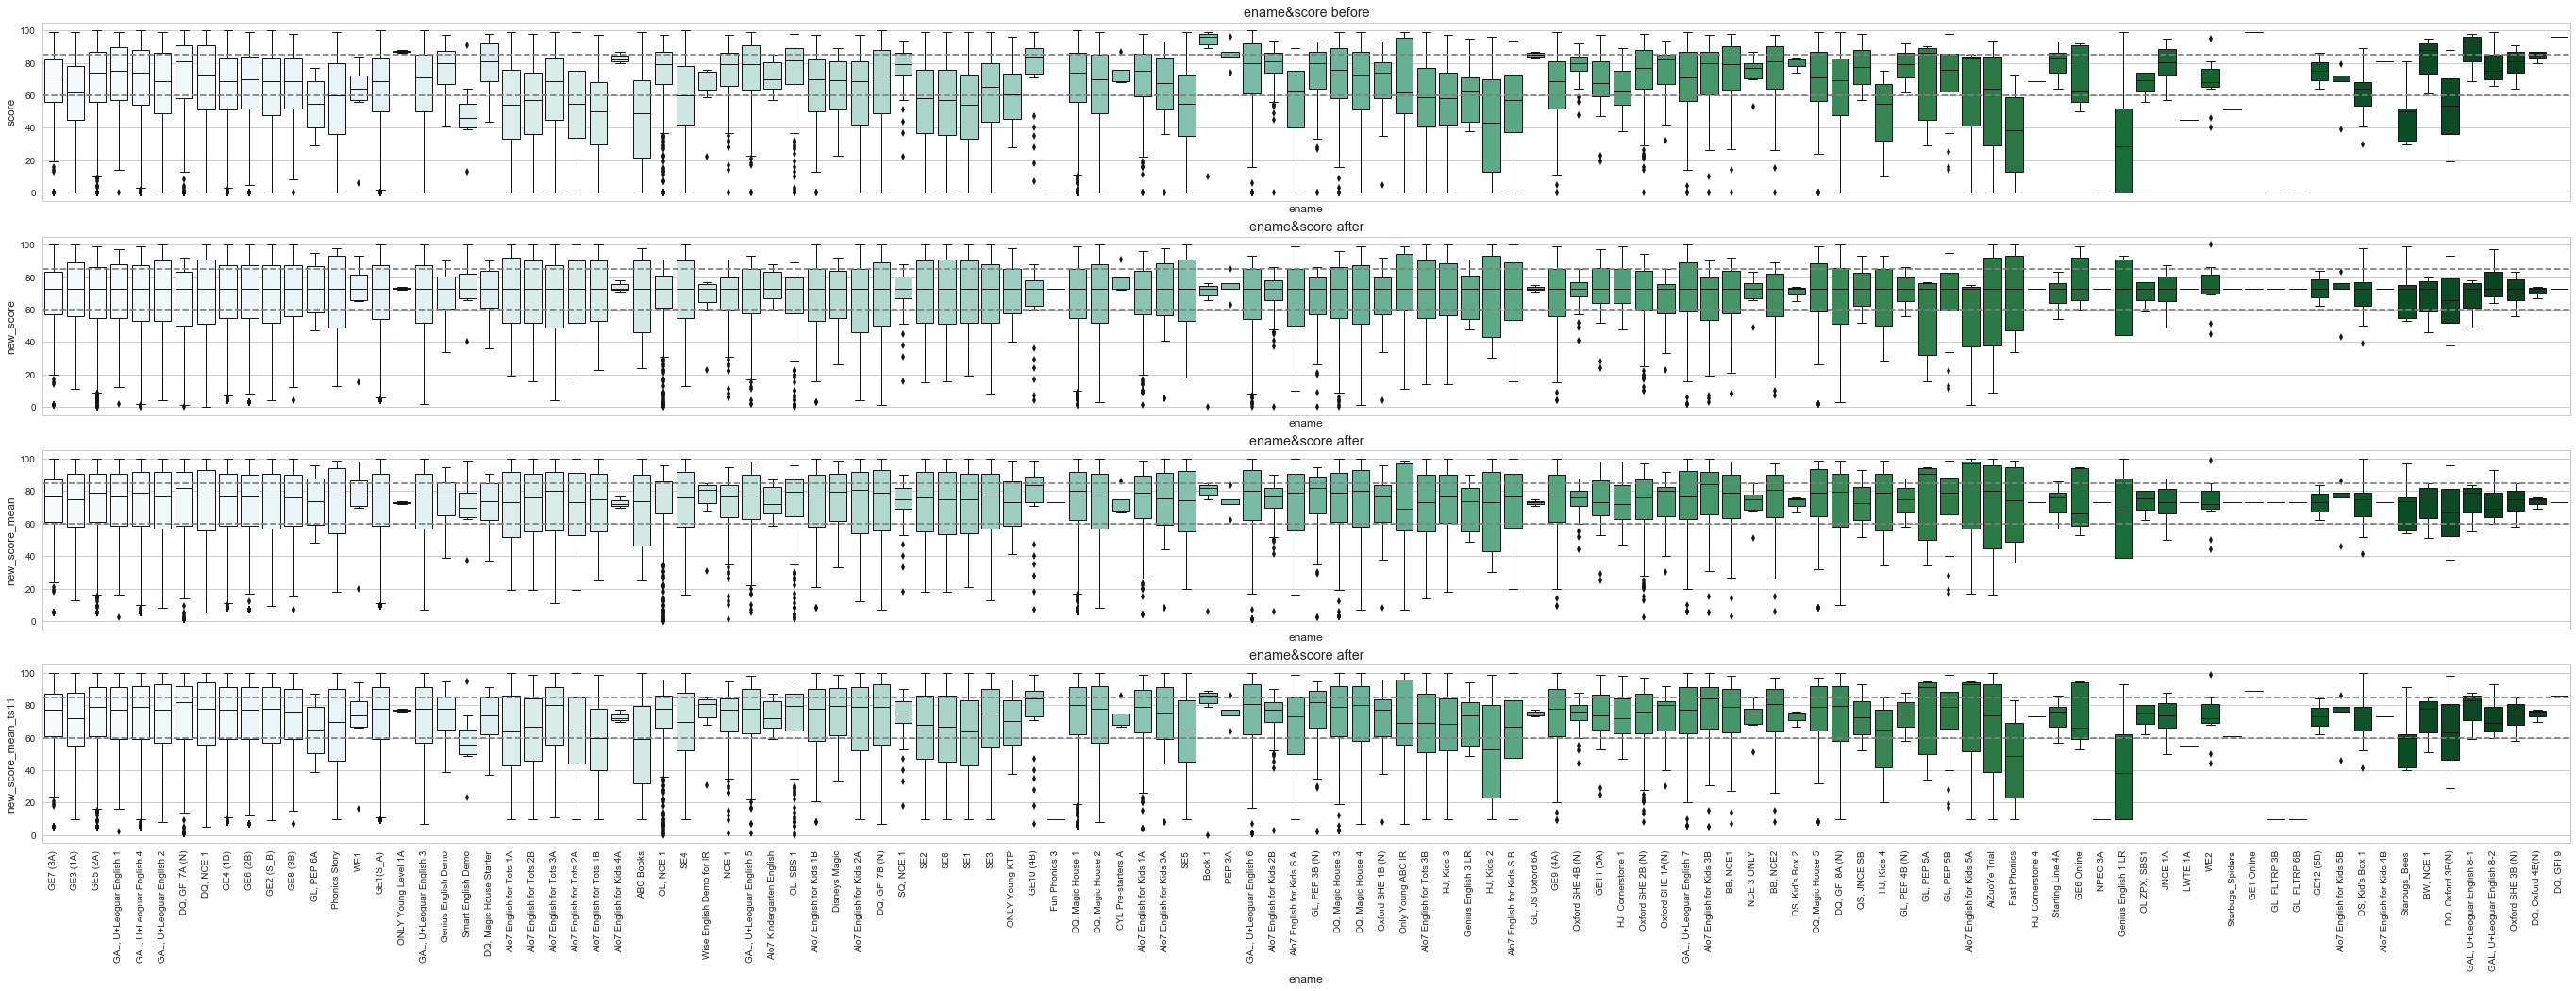

In [962]:
# 划分前后教材的分数分布
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(48, 16), sharex=True)

sns.boxplot(x="ename", y="score", data=df_young, palette='BuGn',linewidth=1, ax=ax1)
ax1.axhline(60, linestyle='--', color='grey')
ax1.axhline(85, linestyle='--', color='grey')
ax1.set_title('ename&score before')

sns.boxplot(x="ename", y="new_score", data=df_young, palette='BuGn',linewidth=1, ax=ax2)
ax2.axhline(60, linestyle='--', color='grey')
ax2.axhline(85, linestyle='--', color='grey')
ax2.set_title('ename&score after')

sns.boxplot(x="ename", y="new_score_mean", data=df_young, palette='BuGn',linewidth=1, ax=ax3)
ax3.axhline(60, linestyle='--', color='grey')
ax3.axhline(85, linestyle='--', color='grey')
ax3.set_title('ename&score after')

sns.boxplot(x="ename", y="new_score_mean_ts11", data=df_young, palette='BuGn',linewidth=1, ax=ax4)
ax4.axhline(60, linestyle='--', color='grey')
ax4.axhline(85, linestyle='--', color='grey')
ax4.set_title('ename&score after')

plt.xticks(rotation=90)

In [982]:
df_young.ename.value_counts().index.values

array([u'GE2 (S_B)', u'GE1(S_A)', u'GE4 (1B)',
       u'GAL, U+Leoguar English 3', u'GE3 (1A)', u'SE1',
       u'GAL, U+Leoguar English 4', u'DQ, NCE 1', u'GE5 (2A)', u'SE2',
       u'DQ, Magic House 2', u'GE6 (2B)', u'OL, NCE 1', u'DQ, GFI 7A (N)',
       u'GAL, U+Leoguar English 2', u'DQ, Magic House 1', u'SE3',
       u'GE7 (3A)', u'DQ, GFI 7B (N)', u'Oxford SHE 2B (N)',
       u'GAL, U+Leoguar English 6', u'SE4', u'DQ, Magic House 3',
       u'Alo7 English for Tots 3B', u'Alo7 English for Tots 1A',
       u'GAL, U+Leoguar English 5', u'SE6', u'NCE 1', u'OL, SBS 1',
       u'DQ, Magic House 4', u'Alo7 English for Kids 1B',
       u'Alo7 English for Tots 3A', u'Alo7 English for Kids 1A',
       u'Alo7 English for Tots 2B', u'GE8 (3B)',
       u'Alo7 English for Tots 1B', u'Alo7 English for Tots 2A',
       u'Alo7 English for Kids S B', u'SE5', u'Alo7 English for Kids 2A',
       u'GE9 (4A)', u'GAL, U+Leoguar English 1', u'HJ, Kids 3',
       u'Alo7 English for Kids 2B', u'BB, NCE1',


In [977]:
df_young[(df_young.ename == 'GE3 (1A)') & (df_young.new_score_mean_ts11 < 50)]

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt,star,new_score,new_score_mean,new_score_mean_ts11
11647,ok,Shanghai,671665,LEG,"{u'lat': 31.0456, u'lon': 121.3997}",Shanghai,27,"[{u'status': u'bad', u'begin': 2010, u'end': 2...",2018-06-14T07:57:15.720Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,64365360,7,13021,1196,GE3 (1A),64365360,2011-06-07 00:00:00,1,38.0,40.0,37.0
11648,ok,Shanghai,671665,LEG,"{u'lat': 31.0456, u'lon': 121.3997}",Shanghai,32,"[{u'status': u'bad', u'begin': 60, u'end': 380...",2018-06-14T08:13:27.617Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,64365360,7,13021,1196,GE3 (1A),64365360,2011-06-07 00:00:00,1,43.0,45.0,42.0
11652,ok,Shanghai,671978,NaN,"{u'lat': 31.0456, u'lon': 121.3997}",Shanghai,0,"[{u'status': u'missing', u'word': u'These', u'...",2018-06-14T08:32:28.888Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,64365360,7,18473,1196,GE3 (1A),64365360,2011-06-07 00:00:00,1,11.0,13.0,10.0
11663,ok,Changsha,672783,WIG WIT WILL,"{u'lat': 22.3614, u'lon': 112.6877}",Guangdong,32,"[{u'status': u'bad', u'begin': 850, u'end': 12...",2018-06-16T00:29:24.860Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,75676111,10,18478,1196,GE3 (1A),75676111,2008-12-12 00:00:00,1,43.0,45.0,42.0
11664,soft,Changsha,672790,IS AS WAS,"{u'lat': 22.3614, u'lon': 112.6877}",Guangdong,38,"[{u'status': u'bad', u'begin': 330, u'end': 92...",2018-06-16T00:34:09.040Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,75676111,10,18478,1196,GE3 (1A),75676111,2008-12-12 00:00:00,1,49.0,51.0,48.0
11668,ok,Changsha,672835,THUMB,"{u'lat': 22.3614, u'lon': 112.6877}",Guangdong,0,"[{u'status': u'bad', u'begin': 60, u'end': 710...",2018-06-16T00:10:04.411Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,75676111,10,13022,1196,GE3 (1A),75676111,2008-12-12 00:00:00,1,11.0,13.0,10.0
11669,ok,Changsha,672835,THUMB,"{u'lat': 22.3614, u'lon': 112.6877}",Guangdong,1,"[{u'status': u'bad', u'begin': 90, u'end': 770...",2018-06-16T00:10:13.259Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,75676111,10,13022,1196,GE3 (1A),75676111,2008-12-12 00:00:00,1,12.0,14.0,11.0
11688,ok,Hefei,671665,LEG,"{u'lat': 31.8639, u'lon': 117.2808}",Anhui,18,"[{u'status': u'bad', u'begin': 290, u'end': 75...",2018-06-13T05:10:25.534Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,88219280,10,13021,1196,GE3 (1A),88219280,2008-10-19 00:00:00,1,29.0,31.0,28.0
11710,ok,Hefei,610591,DOOR,"{u'lat': 31.8639, u'lon': 117.2808}",Anhui,35,"[{u'status': u'bad', u'begin': 60, u'end': 990...",2018-06-13T04:20:52.320Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,79157029,7,13008,1196,GE3 (1A),79157029,2011-01-22 00:00:00,1,46.0,48.0,45.0
11720,ok,Shanghai,611606,THAT,"{u'lat': 31.0456, u'lon': 121.3997}",Shanghai,16,"[{u'status': u'missing', u'word': u""What's"", u...",2018-06-13T07:33:47.394Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,86446336,7,18442,1196,GE3 (1A),86446336,2011-05-07 00:00:00,1,27.0,29.0,26.0


In [978]:
df_young[(df_young.ename == 'GE3 (1A)') & (df_young.new_score_mean_ts11 < 50)].url.values

array([u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/14/07/64365360/671665/5ac9ae3852b731e712b97a3c73e9ad77.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/14/08/64365360/671665/2c62d6e5ddb57815d875f49b56e3274a.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/14/08/64365360/671978/3c55158a7aed866dde0531c5647063e8.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/75676111/672783/836c023f8d3e1f8c8773ec49c6a0a009.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/75676111/672790/a70c18892f6a20371aa004e80e33def7.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/75676111/672835/8404e3ddee990bc39a306c4d7b8961bf.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/16/00/75676111/672835/bc4470c096d70bc0f1639a4fd025d17f.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/13/05/88219280/671665/70ccc320eaa217e2c83ff3c

In [987]:
df_young[df_young.ename =='Alo7 English for Kids 4A']

,audio_quality,city_name,exercise_id,hyp_text,location,region_name,score,segments,timestamp,url,user_id,age,course_unit_id,course_id,ename,pspt_id,birth_dt,star,new_score,new_score_mean,new_score_mean_ts11
6303,ok,Kunming,300101,I HAVE NEVER LOOKED AT A RAINBOW,"{u'lat': 25.0389, u'lon': 102.7183}",Yunnan,87,"[{u'status': u'ok', u'begin': 490, u'end': 750...",2018-06-10T04:26:15.960Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,69347002,11,5990,416,Alo7 English for Kids 4A,69347002,2007-01-01 00:00:00,3,78.0,77.0,77.0
6304,ok,Guangzhou,289773,I WILL GO TO THE SEASIDE FOR MY HOLIDAY,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,80,"[{u'status': u'ok', u'begin': 840, u'end': 108...",2018-06-10T04:17:00.567Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,25770296,13,5977,416,Alo7 English for Kids 4A,25770296,2005-10-03 00:00:00,2,71.0,70.0,70.0
6305,ok,Guangzhou,300248,HAVE YOU GIVEN YOUR MOTHER A HUG YET,"{u'lat': 23.1167, u'lon': 113.25}",Guangdong,82,"[{u'status': u'ok', u'begin': 240, u'end': 590...",2018-06-15T05:54:21.164Z,https://s3.cn-north-1.amazonaws.com.cn/dsr-pro...,34910304,10,5993,416,Alo7 English for Kids 4A,34910304,2008-01-01 00:00:00,2,73.0,72.0,72.0


In [986]:
df_young[df_young.ename =='Alo7 English for Kids 4A'].url.values

array([u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/10/04/69347002/300101/51fb9471c4947baa5087faaa07e6f9a5.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/10/04/25770296/289773/a3d8f651d351924c287951dfddd948eb.wav',
       u'https://s3.cn-north-1.amazonaws.com.cn/dsr-proxy/2018/06/15/05/34910304/300248/aaaf03842948142cfb2e5227504c4dd5.wav'],
      dtype=object)